In [1]:
import astropy.units as u
def makeStacks(path,timeStamps,channels=['94','131','171','193','211','304','335'],initCoords=[0*u.arcsec,0*u.arcsec],ROIsize=300*u.arcsec,rotationCorr=1,threads=1,clusterScale=16):
    ### Create the cluster
    import dask
    import distributed
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster(threads_per_worker=threads)
    cluster.scale(clusterScale)
    client = Client(cluster)
    
    import astropy.units as u
    import sunpy.map
    import time
    import numpy as np
    import drms
    from astropy.coordinates import SkyCoord
    from sunpy.util.metadata import MetaDict
    import sunpy.io.fits
    from sunpy.map import Map
    import os 
    from sunpy.physics import solar_rotation
    import astropy.time
    from astropy.visualization import ImageNormalize, SqrtStretch, time_support
    from aiapy.calibrate import correct_degradation
    from aiapy.calibrate.util import get_correction_table
    from aiapy.calibrate import register, update_pointing
    
    ### Get correction table
    import warnings
    warnings.filterwarnings('ignore')
    #correction_table = get_correction_table()
    correction_table = get_correction_table(correction_table='/ssw/sdo/aia/response/aia_V8_20171210_050627_response_table.txt')
    import warnings
    warnings.filterwarnings('default')
    
    ### Get images
    client_drms = drms.Client()
    keys_aia_tot = []
    paths_aia_tot = []
    for j in range(len(timeStamps[:])):
        keys_aia = []
        paths_aia = []
        for i in range(len(channels)):
          keys,paths = client_drms.query(
              'aia.lev1_euv_12s['+timeStamps[j]+']['+channels[i]+']',
              key=drms.const.all,
              seg='image',
          )
          keys_aia.append(keys)
          paths_aia.append(paths)
        keys_aia_tot.append(keys_aia)
        paths_aia_tot.append(paths_aia)
    
    ### Define the Dask function for distributed computing
    def getFrame(args):

      i = args[0]
      timeStamp = args[1]
      x0 = args[2][0]
      y0 = args[2][1]
      ROIsize = args[3]
      correction_table = args[4]
      path = args[5]
      keys = args[6]
      paths = args[7]
      m_aia_init = args[8]
      rotationCorr = args[9]
        
      stack= []
      noisey_stack = []
      level_1_noise = []
      for j in range(len(channels)):
          m_aia = sunpy.map.Map(paths[i][j]['image'][0])
        
          # Create noisey map
          noise_data = m_aia.data
          noise_meta = m_aia.meta
          # We set all negatives to 0 because you cannot have a have a negative mean for the poisson draw
          # If you instead offset by 100 or another value the distribution will be fundementally different 
          # which is a problem espessialy when scaling the channels
          np.random.seed(0)
          #noise_data = noise_data + 10
          noise_data[noise_data<0] = 1
          noise_data = np.random.poisson(noise_data)
          m_noise_aia = sunpy.map.Map(noise_data,noise_meta)
        
          # Isolate level 1 noise for analysis
          level_1_placeholder = m_aia
          level_1_noise_placeholder = m_noise_aia

          # Back to original map
          m_normalized_aia = sunpy.map.Map(
            m_aia.data/m_aia.exposure_time.to(u.s).value,
            m_aia.meta
          )
          m_updated_pointing_aia = update_pointing(m_normalized_aia)
          m_registered_aia = register(m_updated_pointing_aia)
          m_corrected_aia = correct_degradation(m_registered_aia,correction_table=correction_table)
          maps_frame_aia = m_corrected_aia
          #maps_frame_aia = m_registered_aia
          ###
          # Adjust for shift in images and apply it to x0 and y0
          ###
          if rotationCorr == 1:
              adjustMaps = sunpy.map.Map(m_aia_init,maps_frame_aia,sequence=True)
              adjust = sunpy.physics.solar_rotation.calculate_solar_rotate_shift(adjustMaps)
              x0 = x0 - adjust['x'][1]
              y0 = y0 - adjust['y'][1]
          ###
          bottom_left_aia = SkyCoord(x0 - ROIsize, y0 - ROIsize,
                               frame=maps_frame_aia.coordinate_frame)
          top_right_aia = SkyCoord(x0 + ROIsize, y0 + ROIsize,
                             frame=maps_frame_aia.coordinate_frame)
          submap_frame_aia = maps_frame_aia.submap(bottom_left_aia,top_right_aia)
                                                                                    
          # Back to noisey map                                    
          m_normalized_noise_aia = sunpy.map.Map(
            m_noise_aia.data/m_noise_aia.exposure_time.to(u.s).value,
            m_noise_aia.meta
          )
          m_updated_pointing_noise_aia = update_pointing(m_normalized_noise_aia)
          m_registered_noise_aia = register(m_updated_pointing_noise_aia)
          m_corrected_noise_aia = correct_degradation(m_registered_noise_aia,correction_table=correction_table)
          maps_frame_noise_aia = m_corrected_noise_aia
          #maps_frame_noise_aia = m_registered_noise_aia
    
          bottom_left_noise_aia = SkyCoord(x0 - ROIsize, y0 - ROIsize,
                               frame=maps_frame_noise_aia.coordinate_frame)
          top_right_noise_aia = SkyCoord(x0 + ROIsize, y0 + ROIsize,
                             frame=maps_frame_noise_aia.coordinate_frame)
          submap_frame_noise_aia = maps_frame_noise_aia.submap(bottom_left_noise_aia,top_right_noise_aia)
            
          # Create submaps for level 1 noise, we are doing this down here so x0 and y0 can be updated if rotation is turned on
          xScale = level_1_placeholder.scale[0].value
          yScale = level_1_placeholder.scale[1].value
          xCenterPixel = np.floor(x0.value/xScale)+(level_1_placeholder.data.data.shape[0]/2)
          yCenterPixel = np.floor(y0.value/yScale)+(level_1_placeholder.data.data.shape[0]/2)
          # Cut to same size across channels so they can be stacked, the actual arcsec FOV doesn't matter since this will be used for a histogram  
          cutSizeX = submap_frame_aia.data.shape[0]
          cutSizeY = submap_frame_aia.data.shape[1]
          if cutSizeX%2 == 1:
            leftX = xCenterPixel-(cutSizeX-1)/2
            rightX = xCenterPixel+(cutSizeX-1)/2+1
          else:
            leftX = xCenterPixel-(cutSizeX)/2
            rightX = xCenterPixel+(cutSizeX)/2
          if cutSizeY%2 == 1:
            bottomY = yCenterPixel-(cutSizeY-1)/2
            topY = yCenterPixel+(cutSizeY-1)/2+1
          else:
            bottomY = yCenterPixel-(cutSizeY)/2
            topY = yCenterPixel+(cutSizeY)/2
          lvl1_submap = level_1_placeholder.data[int(leftX):int(rightX),int(bottomY):int(topY)]
          lvl1_noise_submap = level_1_noise_placeholder.data[int(leftX):int(rightX),int(bottomY):int(topY)]
            
          # Compile stacks 
          level_1_noise.append(lvl1_noise_submap-lvl1_submap)  
          stack.append(submap_frame_aia.data)
          noisey_stack.append(submap_frame_noise_aia.data)
      #return stack, noisey_stack, level_1_noise
      return np.stack(stack), np.stack(noisey_stack), np.stack(level_1_noise);
      
    ### Create loop for Dask function
    m_aia_init0 = sunpy.map.Map(paths_aia_tot[0][0]['image'][0])
    m_updated_pointing_aia_init = update_pointing(m_aia_init0)
    m_aia_init  = register(m_updated_pointing_aia_init)
    lazy_results = []
    for i in range(len(timeStamps)):
      args = [i,timeStamps[i],initCoords,ROIsize,correction_table,path,keys_aia_tot,paths_aia_tot,m_aia_init,rotationCorr]
      lazy = dask.delayed(getFrame)(args)
      lazy_results.append(lazy)
    ### Execute function
    stacks = dask.compute(lazy_results)
    client.close()
    cluster.close()
    #return stacks
    return np.squeeze(np.stack(stacks[0],axis=1))[0],np.squeeze(np.stack(stacks[0],axis=1))[1],np.squeeze(np.stack(stacks[0],axis=1))[2];

In [2]:
###
# Intall aiapy, sunpy, graphviz
###
import astropy.units as u
import os

import warnings
warnings.filterwarnings('ignore')

path = '/Users/penwarden/Desktop/'

# Get training data
tStart = ''
tLength = '1h'
tCadence = '1440s'
trainStamps = ['2010-07-15T00:00:00','2010-07-16T00:00:00','2010-06-14T00:00:00','2010-06-15T00:00:00']
rotationCorr = 0
ROIsize=500*u.arcsec
initCoords = [51*u.arcsec,248*u.arcsec]
#threads = 1
#clusterScale = 16
import warnings
warnings.filterwarnings('ignore')
trainStack, trainNoiseStack, level_1_trainNoise = makeStacks(path,trainStamps,initCoords=initCoords,rotationCorr=rotationCorr,ROIsize=ROIsize)
import warnings
warnings.filterwarnings('default')

# Get testing data
initCoords = [-44*u.arcsec,-49*u.arcsec]
testStamps = ['2017-08-26T02:52:58','2018-08-26T00:00:00']

#initCoords = [83*u.arcsec,126*u.arcsec]
#testStamps = ['2010-08-15T00:00:00','2011-01-28T00:00:00']
import warnings
warnings.filterwarnings('ignore')
testStack, testNoiseStack, level_1_testNoise = makeStacks(path,testStamps,initCoords=initCoords,rotationCorr=rotationCorr,ROIsize=ROIsize)
import warnings
warnings.filterwarnings('default')

/opt/anaconda3/lib/python3.7/site-packages/distributed/worker.py:3390: UserWarning: Large object of size 134.89 MB detected in task graph: 
  ([3, '2010-06-15T00:00:00', [<Quantity 51. arcsec> ... , -15.]]), 0],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


In [3]:
def stackPlotter(names,stacks,file_name,histName,channels=['94','131','171','193','211','304','335'],cmaps=['sdoaia94','sdoaia131','sdoaia171','sdoaia193','sdoaia211','sdoaia304','sdoaia335']):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(5*len(channels),5*2.5*len(names)))
    ys = [.15,.01,0.0005]
    bins = 50
    histColor = ['blue','orange','green']
    histCount = 0
    for i in range(len(names)):
        for j in range(len(channels)):
            histCount = int(np.floor(i/3)+1)
            plt.subplot(len(names)*2,len(channels),i*7+histCount*7+j+1), plt.imshow(stacks[i][j],cmap=cmaps[j]),plt.title(names[i]+' '+channels[j],fontsize=25),plt.xlabel('Pixel',fontsize=10),plt.ylabel('Pixel',fontsize=10)
            
            mean = np.mean(stacks[i][j])
            std = np.std(stacks[i][j])
            median = np.median(stacks[i][j])
            centerThree = (histCount-1)*3+1
            listMean = [np.mean(stacks[centerThree-1][j]),np.mean(stacks[centerThree][j]),np.mean(stacks[centerThree+1][j])]
            listSTD = [np.std(stacks[centerThree-1][j]),np.std(stacks[centerThree][j]),np.std(stacks[centerThree+1][j])]
            annotate = histName[int(i%3)]+'\nmean: '+str(round(mean,2))+'\nstd: '+str(round(std,2))+'\nmedian '+str(round(median,2))
            xmax = np.max(np.concatenate([stacks[centerThree-1][j].flatten(),stacks[centerThree][j].flatten(),stacks[centerThree+1][j].flatten()]))
            xmin = np.min(np.concatenate([stacks[centerThree-1][j].flatten(),stacks[centerThree][j].flatten(),stacks[centerThree+1][j].flatten()]))

            plt.subplot(len(names)*2,len(channels),histCount*28+j+1), plt.hist(stacks[i][j].flatten(),bins=bins,alpha=0.5,density=True,range=[xmin,xmax]),plt.title('Histograms',fontsize=25),plt.xlabel('Pixel Value',fontsize=10),plt.ylabel('Count',fontsize=10)
            plt.gca().set_yscale("log")
            #plt.gca().set_xscale("log")
            yposList = np.concatenate([np.histogram(stacks[centerThree-1][j],bins=bins,density=True,range=[xmin,xmax])[0],np.histogram(stacks[centerThree][j],bins=bins,density=True,range=[xmin,xmax])[0],np.histogram(stacks[centerThree+1][j],bins=bins,density=True,range=[xmin,xmax])[0]])
            ypos = np.max(yposList)/2*ys[int(i%3)]
            xpos = np.max(listMean)+np.max(listSTD)*10
            annotate = histName[int(i%3)]+'\nmean: '+str(round(mean,2))+'\nstd: '+str(round(std,2))+'\nmedian '+str(round(median,2))
            plt.annotate(annotate,xy=(xpos,ypos),color=histColor[int(i%3)],ha='center');
            plt.xlim([np.max(listMean)-7*np.max(listSTD),np.max(listMean)+21*np.max(listSTD)])
    plt.savefig(file_name)
    plt.show()

In [4]:
import numpy as np
def trainShapeStack (stack,stackNoise,scaleStack):
    shapeInput = [len(stack),stack[0].shape[0]*stack[0].shape[1]]
    norm = []
    for i in range(len(stack)):
        norm.append(stack[i]/np.median(scaleStack[i]))
    normData = np.stack(norm)
    cleanData = np.transpose(np.reshape(normData,shapeInput))

    combine = []
    noiseData = []
    for i in range(len(stackNoise)):
        combine.append(stackNoise[i]/np.median(scaleStack[i]))
    noiseData = np.transpose(np.reshape(np.stack(combine),shapeInput))
    
    return normData, cleanData, combine, noiseData

In [5]:
scaleStack = np.mean(trainStack,0)

normData = [];cleanData = [];combineData = [];noiseData =[]
norm = [];clean= [];combine= [];noise=[]
for i in range(trainStack.shape[0]):
    norm, clean, combine, noise = trainShapeStack(trainStack[i],trainNoiseStack[i],scaleStack)
    normData.append(norm),cleanData.append(clean),combineData.append(combine),noiseData.append(noise) 
NNshape = [cleanData[0].shape[0]*len(cleanData),cleanData[0].shape[1]]
NNcleanTrain = np.reshape(np.stack(cleanData),NNshape)
NNnoiseTrain = np.reshape(np.stack(noiseData),NNshape)

In [70]:
# Set seed for consitant results
seed_value= 3
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Dropout
from keras.models import Model

input_pixel = Input(shape=(7,))
layer_0 = Dense(units=7,activation='relu')(input_pixel)
#drop_layer_1 = Dropout(rate=.2)(input_pixel)
layer_1 = Dense(units=6,activation='relu')(layer_0)
#drop_layer_2 = Dropout(rate=.2)(layer_1)
#layer_2 = Dense(units=4,activation='relu')(drop_layer_2)
#drop_layer_3 = Dropout(rate=.2)(layer_2)
encoded = Dense(units=4,activation='relu')(layer_1)
#drop_layer_4 = Dropout(rate=.2)(encoded)
#layer_3 = Dense(units=4,activation='relu')(drop_layer_4)
#drop_layer_5 = Dropout(rate=.2)(layer_3)
layer_4 = Dense(units=6,activation='relu')(encoded)
decoded = Dense(units=7,activation='relu')(layer_4)
autoencoder = keras.Model(input_pixel,decoded,loss_weights=[1,0,0,0,0,0,1])
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 48        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 28        
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 30        
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 49        
Total params: 211
Trainable params: 211
Non-trainable params: 0
_____________________________________________________________

In [71]:
from keras.optimizers import Adam
autoencoder.compile(optimizer=Adam(lr=0.001),loss='mean_squared_error')

In [72]:
history = autoencoder.fit(NNcleanTrain,NNcleanTrain,epochs=5,batch_size=1000,validation_split=.2,shuffle=True)
#autoencoder.fit(noiseData[0],noiseData[0],epochs=5,batch_size=1000,validation_split=.2)

Epoch 1/5
8904/8904 [==============================] - 11s 1ms/step - loss: 0.4391 - val_loss: 0.0693
Epoch 2/5
8904/8904 [==============================] - 12s 1ms/step - loss: 0.1806 - val_loss: 0.0753
Epoch 3/5
8904/8904 [==============================] - 11s 1ms/step - loss: 0.1756 - val_loss: 0.0809
Epoch 4/5
8904/8904 [==============================] - 11s 1ms/step - loss: 0.1705 - val_loss: 0.0816ETA
Epoch 5/5
8904/8904 [==============================] - 11s 1ms/step - loss: 0.1682 - val_loss: 0.0811


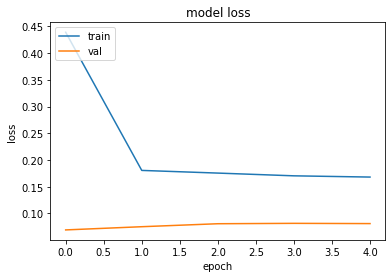

In [73]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [74]:
def testShapeStack (stack,stackNoise,scaleStack):
    shapeInput = [len(stack),stack[0].shape[0]*stack[0].shape[1]]
    norm = []
    for i in range(len(stack)):
        norm.append(stack[i]/np.median(scaleStack[i]))
    normTestData = np.stack(norm)
    cleanTestData = np.transpose(np.reshape(normTestData,shapeInput))

    combineTest = []
    noiseTestData = []
    for i in range(len(stackNoise)):
        combineTest.append(stackNoise[i]/np.median(scaleStack[i]))
    noiseTestData = np.transpose(np.reshape(np.stack(combineTest),shapeInput))
    return normTestData, cleanTestData, combineTest, noiseTestData

In [75]:
normTestData = [];cleanTestData = [];combineTestData = [];noiseTestData =[]
norm = [];clean= [];combine= [];noise=[]
for i in range(testStack.shape[0]):
    norm, clean, combine, noise = testShapeStack(testStack[i],testNoiseStack[i],scaleStack)
    normTestData.append(norm),cleanTestData.append(clean),combineTestData.append(combine),noiseTestData.append(noise) 
NNcleanTest = np.stack(cleanTestData)
NNnoiseTest = np.stack(noiseTestData)

In [76]:
shapeOutput = [len(testStack[0]),testStack[0][0].shape[0],testStack[0][0].shape[1]]

In [77]:
predictedTest = autoencoder.predict(NNnoiseTest[0])
denoiseTestDataAR = np.reshape(np.transpose(predictedTest),shapeOutput)

In [78]:
predictedTest = autoencoder.predict(NNnoiseTest[1])
denoiseTestDataQS = np.reshape(np.transpose(predictedTest),shapeOutput)

In [79]:
#denoiseOnlyAR = np.stack(normTestData)[0]-denoiseTestDataAR
#denoiseOnlyQS = np.stack(normTestData)[1]-denoiseTestDataQS
denoiseOnlyAR = denoiseTestDataAR-np.stack(normTestData)[0]
denoiseOnlyQS = denoiseTestDataQS-np.stack(normTestData)[1]

In [80]:
noiseOnlyAR = np.stack(combineTestData)[0]-np.stack(normTestData)[0]
noiseOnlyQS = np.stack(combineTestData)[1]-np.stack(normTestData)[1]

In [81]:
def rescale (stack,scaleStack):
    newStack = []
    for i in range(len(stack)):
        newStack.append(stack[i]*np.median(scaleStack[i]))
    return np.stack(newStack)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


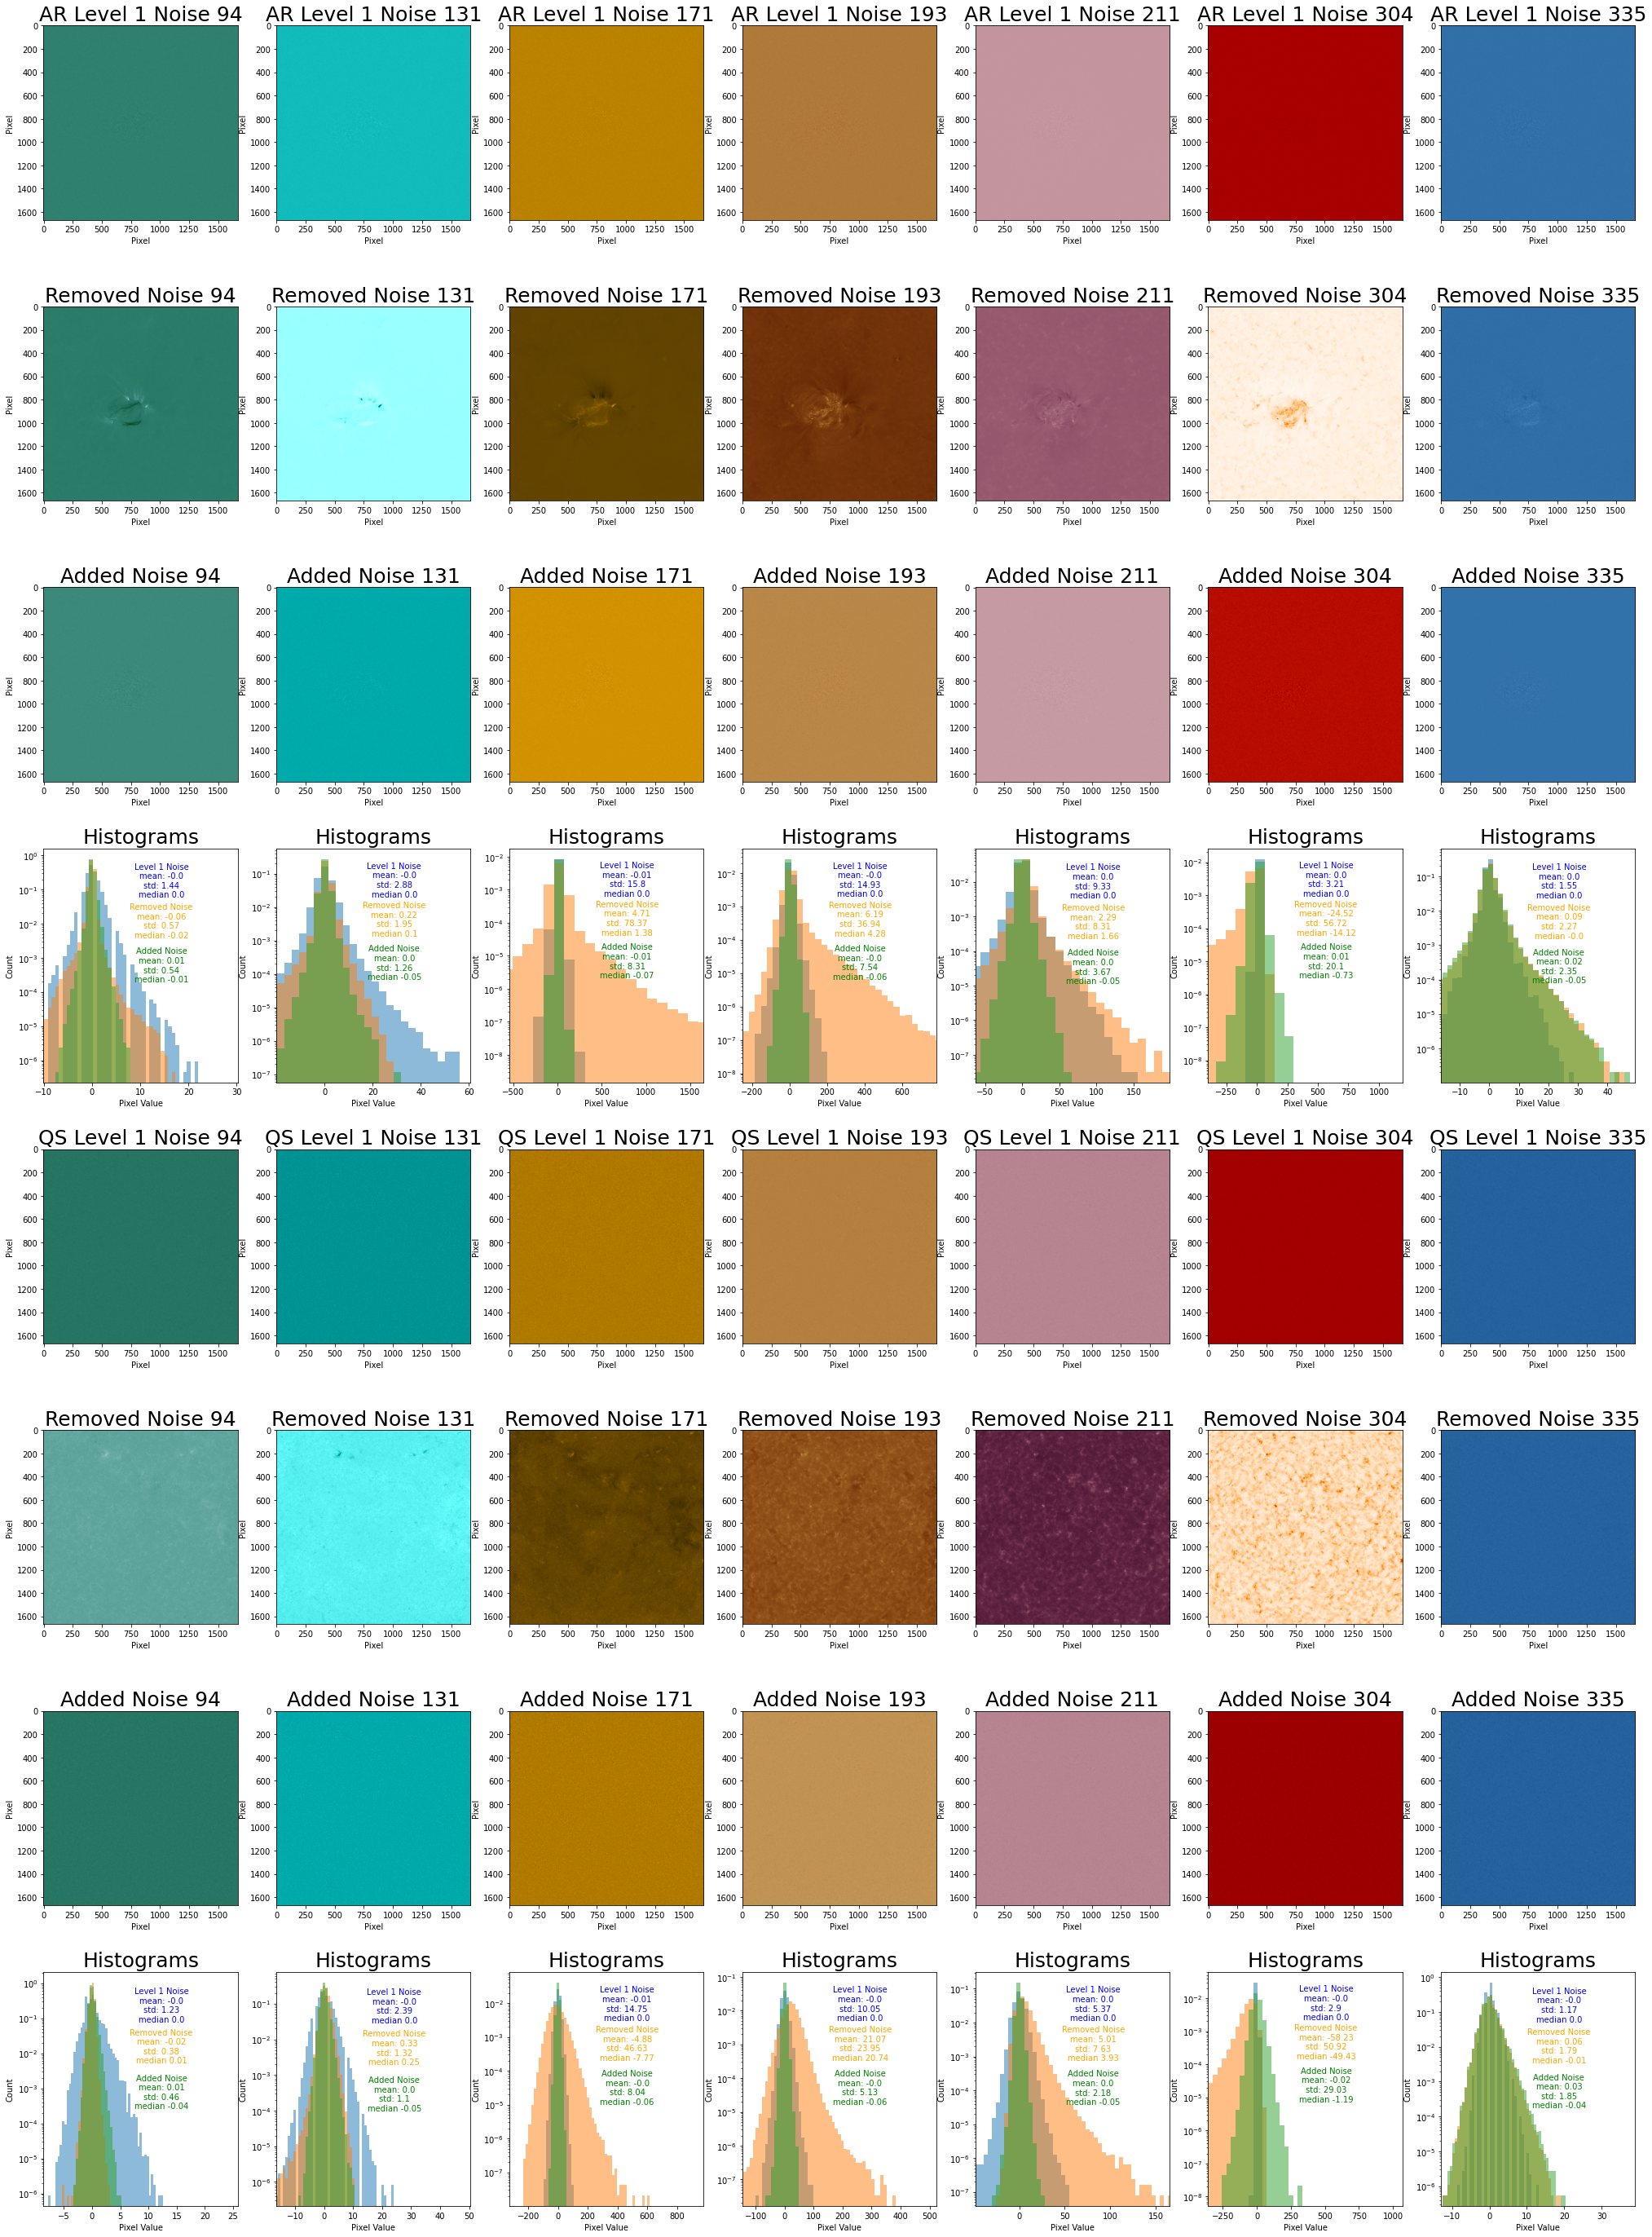

In [82]:
names = ['AR Level 1 Noise','Removed Noise','Added Noise','QS Level 1 Noise','Removed Noise','Added Noise']
stacks = [level_1_testNoise[0],rescale(denoiseOnlyAR,scaleStack),rescale(noiseOnlyAR,scaleStack),
          level_1_testNoise[1],rescale(denoiseOnlyQS,scaleStack),rescale(noiseOnlyQS,scaleStack)]
file_name = 'noise_comp'
histName = ['Level 1 Noise','Removed Noise','Added Noise']
stackPlotter(names,stacks,file_name,histName)

In [83]:
import numpy as np
datDenoise = rescale(denoiseOnlyAR,scaleStack)[0].flatten()
datNoise = rescale(noiseOnlyAR,scaleStack)[0].flatten()
#datLevel1 = level_1_testNoise[0].flatten()
offset = np.min(np.minimum(datNoise,datDenoise))
#datDenoise = denoiseOnlyAR[0].flatten()
#datNoise = noiseOnlyAR[0].flatten()
#xmin = np.min(dat)
#dat = dat - xmin
#xmin = 0; xmax = np.ceil(np.max(dat));mean = np.mean(dat)
histDenoise, bin_edges = np.histogram(datDenoise+10,bins=100,density=True,range=[-2,2])
histNoise, bin_edges = np.histogram(datNoise+10,bins=100,density=True,range=[-2,2])
#histLevel1, bin_edges = np.histogram(datLevel1,bins=100,density=True)
#import scipy
#x = scipy.stats.poisson.pmf(bin_edges[0:-1],mean)

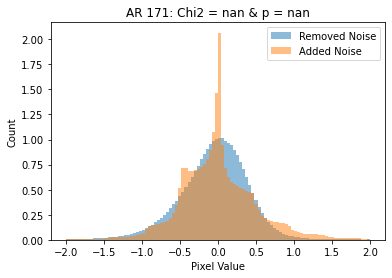

In [84]:
import matplotlib.pyplot as plt
plt.hist(datDenoise,bins=100,density=True,alpha=0.5,range=[-2,2])
plt.hist(datNoise,bins=100,density=True,alpha=0.5,range=[-2,2])
#plt.hist(datLevel1,bins=100,density=True,alpha=0.5,range=[-10,10])
#plt.xlim(0,30)
#plt.gca().set_yscale("log")
import scipy
s, p = scipy.stats.chisquare(histDenoise,histNoise)
plt.legend(['Removed Noise','Added Noise']);
plt.ylabel('Count')
plt.xlabel('Pixel Value');
plt.title('AR 171: '+'Chi2 = '+str(s)+' & p = '+str(p));
plt.savefig('AR171')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


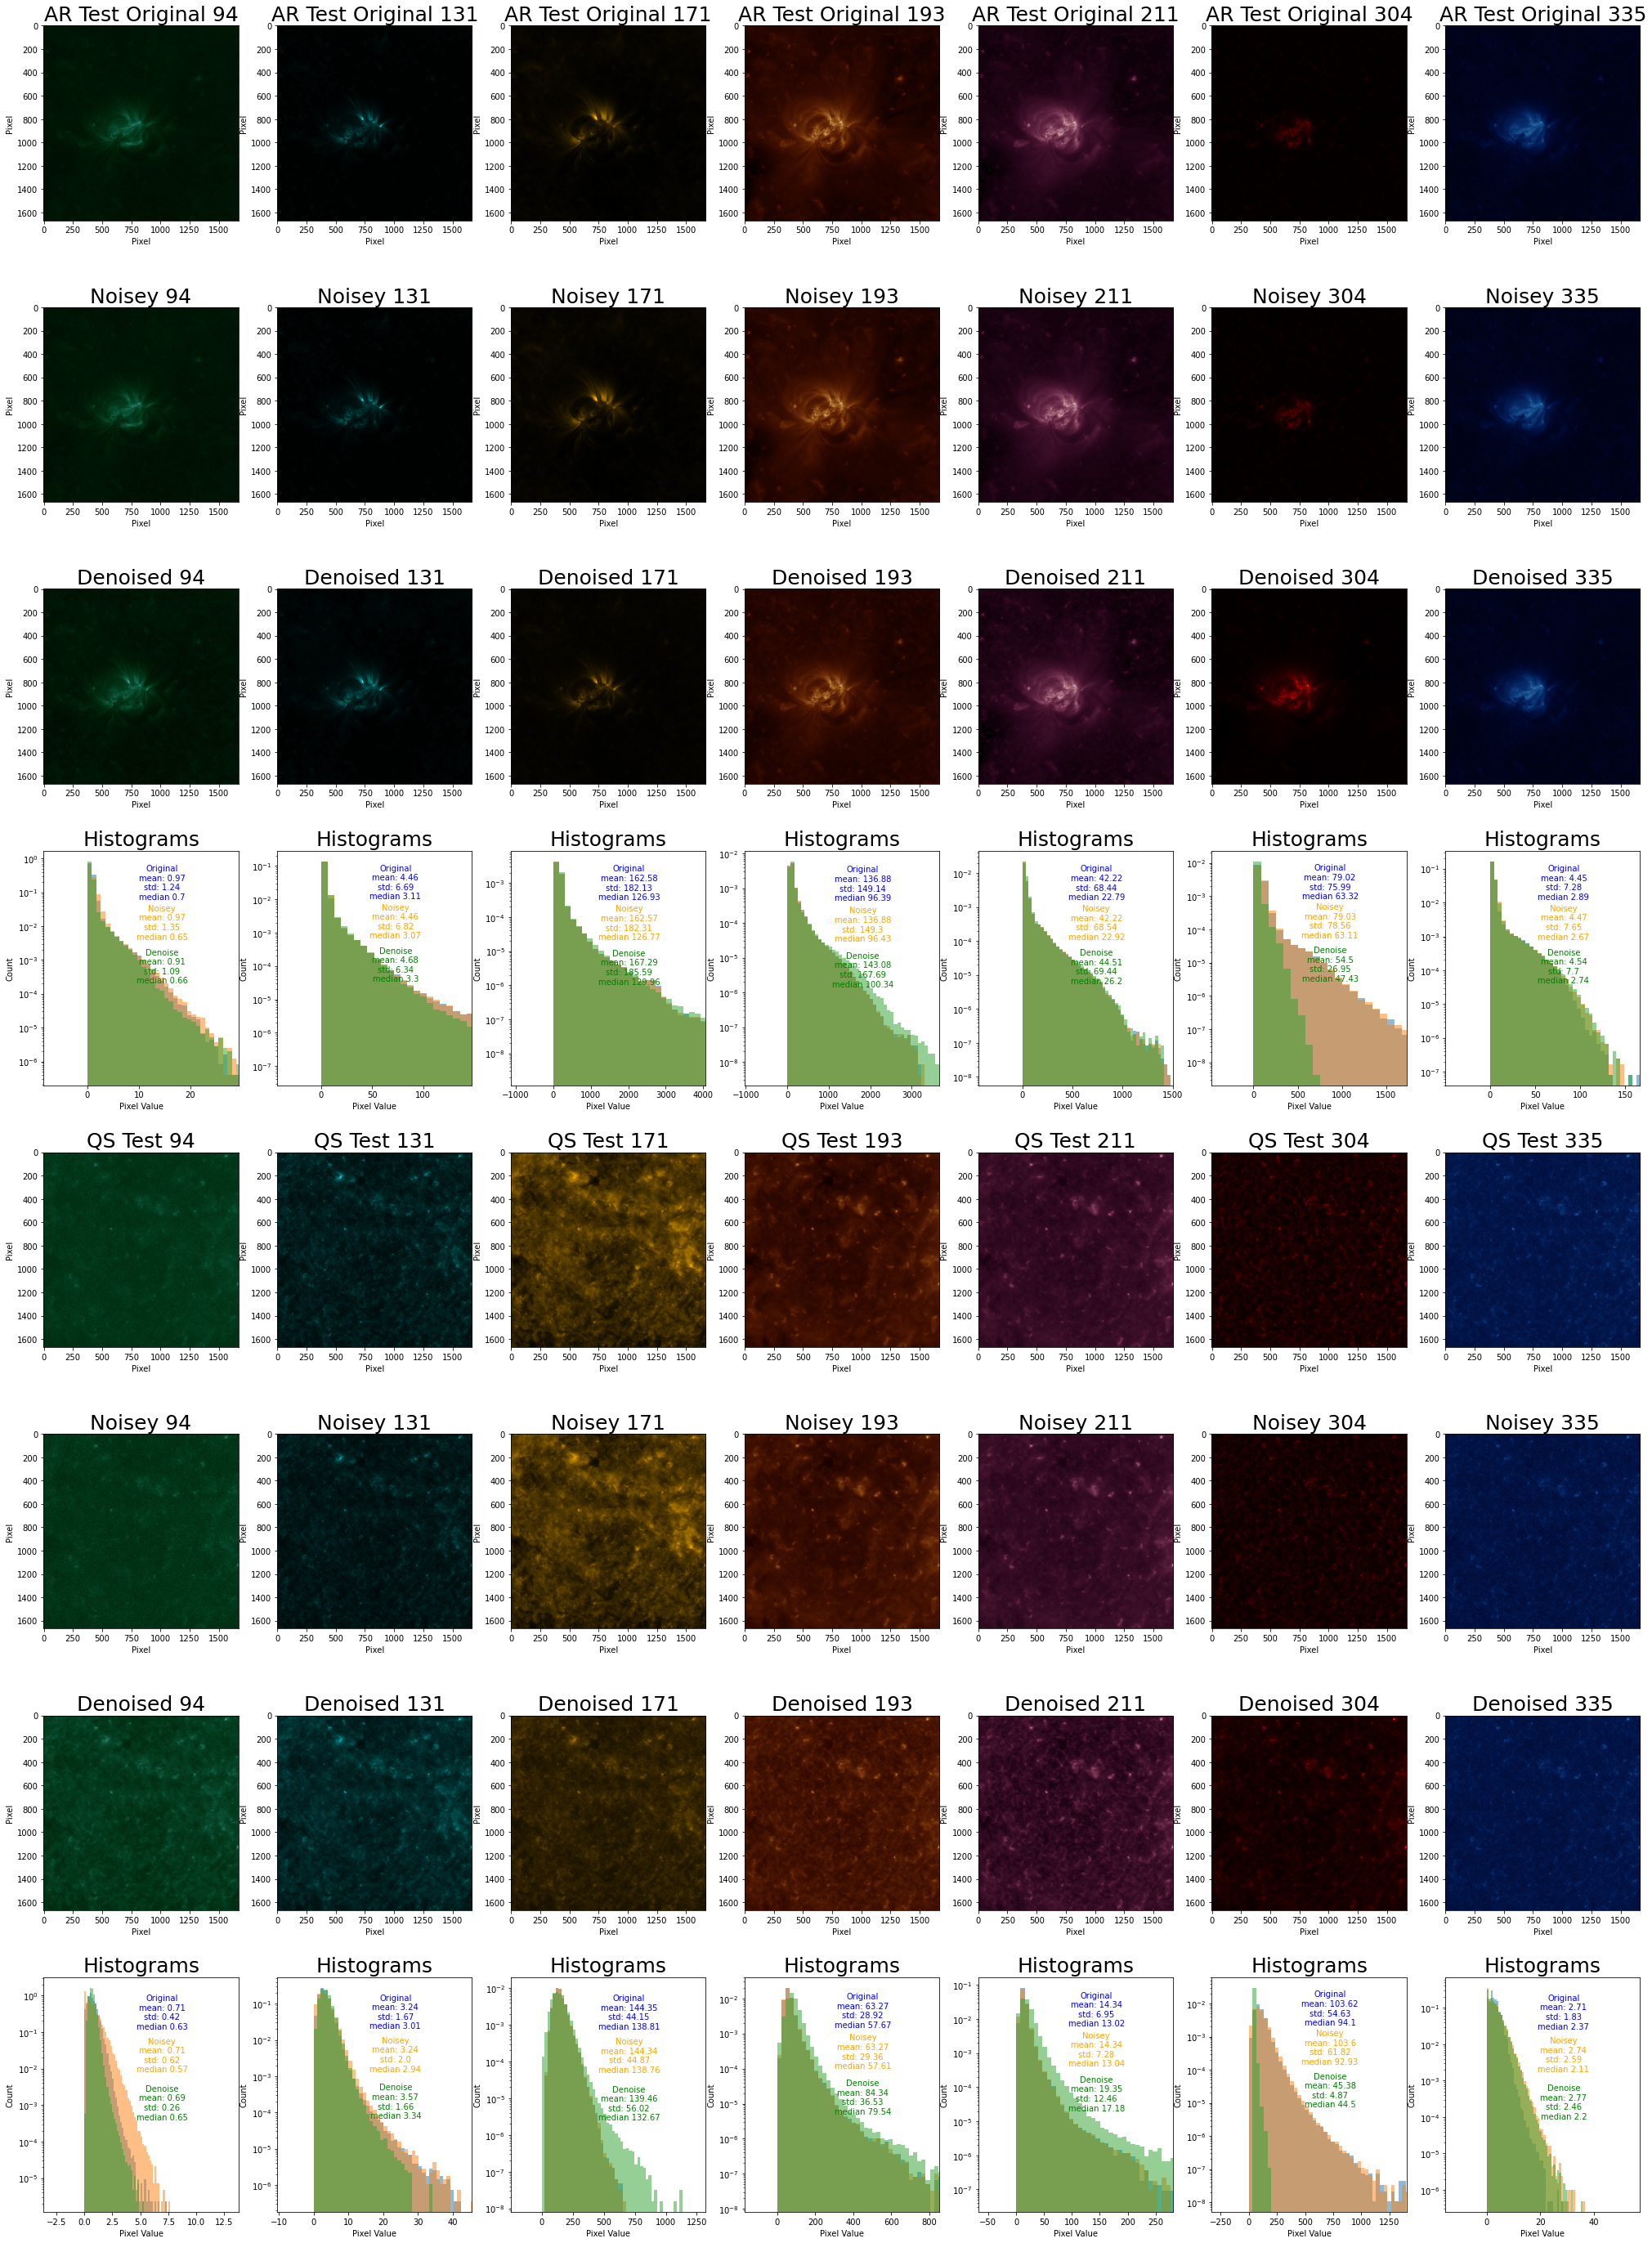

In [85]:
names = ['AR Test Original','Noisey','Denoised','QS Test','Noisey','Denoised']
stacks = [rescale(np.stack(normTestData)[0],scaleStack),rescale(np.stack(combineTestData)[0],scaleStack),rescale(denoiseTestDataAR,scaleStack),
          rescale(np.stack(normTestData)[1],scaleStack),rescale(np.stack(combineTestData)[1],scaleStack),rescale(denoiseTestDataQS,scaleStack)]
file_name = 'denoise_comp'
histName = ['Original','Noisey','Denoise']
stackPlotter(names,stacks,file_name,histName)

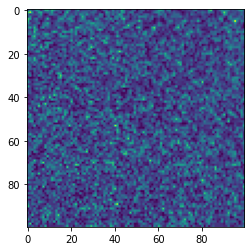

In [86]:
plt.imshow(rescale(np.stack(normTestData)[1],scaleStack)[0][0:100,0:100])

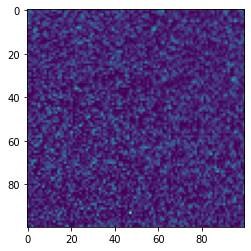

In [87]:
plt.imshow(rescale(np.stack(combineTestData)[1],scaleStack)[0][0:100,0:100])

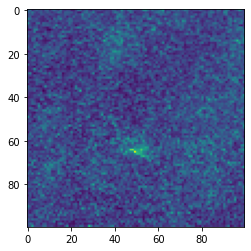

In [88]:
plt.imshow(rescale(denoiseTestDataQS,scaleStack)[0][0:100,0:100])

In [ ]:
#names = ['AR Test','AR Test Noise','AR Test Denoise','QS Test','QS Test Noise','QS Test Denoise']
#stacks = [np.stack(normTestData)[0],np.stack(combineTestData)[0],denoiseTestDataAR,np.stack(normTestData)[1],np.stack(combineTestData)[1],denoiseTestDataQS]
#stackPlotter(names,stacks)

In [393]:
dat = noiseOnlyAR[0].flatten()
xmin = np.min(dat)
dat = dat - xmin
xmin = 0; xmax = np.ceil(np.max(dat));mean = np.mean(dat)
hist, bin_edges = np.histogram(dat,bins=int(xmax),density=True,range=[xmin,xmax])
import scipy
x = scipy.stats.poisson.pmf(bin_edges[0:-1],mean)

In [394]:
int(xmax)

26

ValueError: `bins` must be positive, when an integer

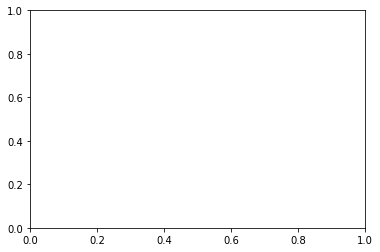

In [395]:
import matplotlib.pyplot as plt
plt.hist(dat,bins=int(xmax)-40,density=True,range=[xmin,xmax])
plt.plot(x)
#plt.xlim(0,30)
s, p = scipy.stats.chisquare(hist,x)
plt.legend(['Poisson','Noise']);
plt.ylabel('Count')
plt.xlabel('Pixel Value');
plt.title('AR 94: '+'Chi2 = '+str(s)+' & p = '+str(p));
plt.savefig('AR94')

In [396]:
dat

array([ 8.90937472, 10.18720961,  9.50516389, ...,  9.23894217,
        9.91440552,  8.80820627])

In [ ]:
import matplotlib.pyplot as plt
plt.hist(dat,bins=18,density=True,range=[0,20])
plt.plot(x)
plt.xlim(0,20)
s, p = scipy.stats.chisquare(hist[0:20],x[0:20])
plt.legend(['Poisson','Noise']);
plt.ylabel('Count')
plt.xlabel('Pixel Value');
plt.title('AR 94: '+'Chi2 = '+str(s)+' & p = '+str(p));
plt.savefig('AR94_cut')